

<img src="assets/eg3.jpg", alt="Photo of Midwestern Home", height="200", width="300">

# Predicting Home Prices in Ames, Iowa

** Author: Jackie Zuker **

** June 2017 **



## Introduction to the Dataset

This dataset comes from the Ames, Iowa Assessor's office and includes various features of homes sold between 2006 and 2010 within the community.

The Ames Housing dataset is comprised of 2930 observations (1460 included in the training dataset) across 82 variables. There are 23 nominal variables, 23 ordinal variables, 14 discrete, and 20 continuous variables. 

**Question of interest: Can the sales price of a home be predicted?** 

Before diving into the statistical analysis, let's get oriented to our dataset. First we see a histogram of the distribution of sales prices of the homes in the dataset. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from scipy import stats

%matplotlib inline

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
homePricesTrain = pd.read_csv("/Users/jacquelynzuker/Desktop/DataScienceBootcamp/Capstone/train.csv")
print("Dimensions of homePricesTrain: ", homePricesTrain.shape)
homePricesTest = pd.read_csv("/Users/jacquelynzuker/Desktop/DataScienceBootcamp/Capstone/test.csv")
print("Dimensions of homePricesTest: ", homePricesTest.shape)

# Set the label of Sale Price to its own variable. 
label = homePricesTrain['SalePrice']
homePricesTrain['Group'] = 'train'
homePricesTest['Group'] = 'test'

# Concatenate the test and training sets so that all feature engineering, data cleaning, etc is applied to both groups.
frames = [homePricesTrain, homePricesTest]
homePrices = pd.concat(frames)
homePricesPCA = homePrices

Dimensions of homePricesTrain:  (1460, 81)
Dimensions of homePricesTest:  (1459, 80)


In [3]:
homePricesTrain.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Group
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,train


#### Distribution of Sale Prices

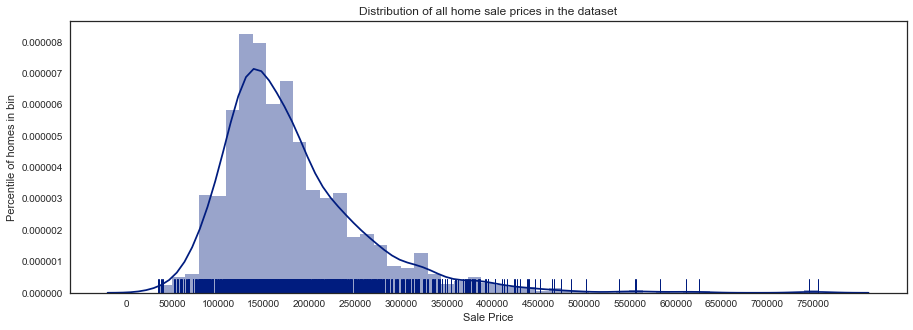

In [4]:
# Histogram of home prices
sns.set(style="white", palette="dark")
plt.figure(figsize=(15,5))
sns.distplot(homePricesTrain["SalePrice"], kde=True, rug=True);
plt.title("Distribution of all home sale prices in the dataset")
plt.xlabel("Sale Price")
plt.ylabel("Percentile of homes in bin")
plt.xticks(np.arange(0, max(homePricesTrain["SalePrice"])+1000, 50000))
plt.show()

#### Neighborhoods

Next we see the general breakdown in the dataset by volume of homes sold and by neighborhood. We can see that the Neighborhood is an important factor of the sale price of the home. 
* ***NridgeHt*** and ***NoRidge homes*** have the highest median Sales prices as well as highest outliers
* ***NAmes*** and ***CollgCr*** neighborhoods had the greatest volume of homes sold during the 4-year period. 


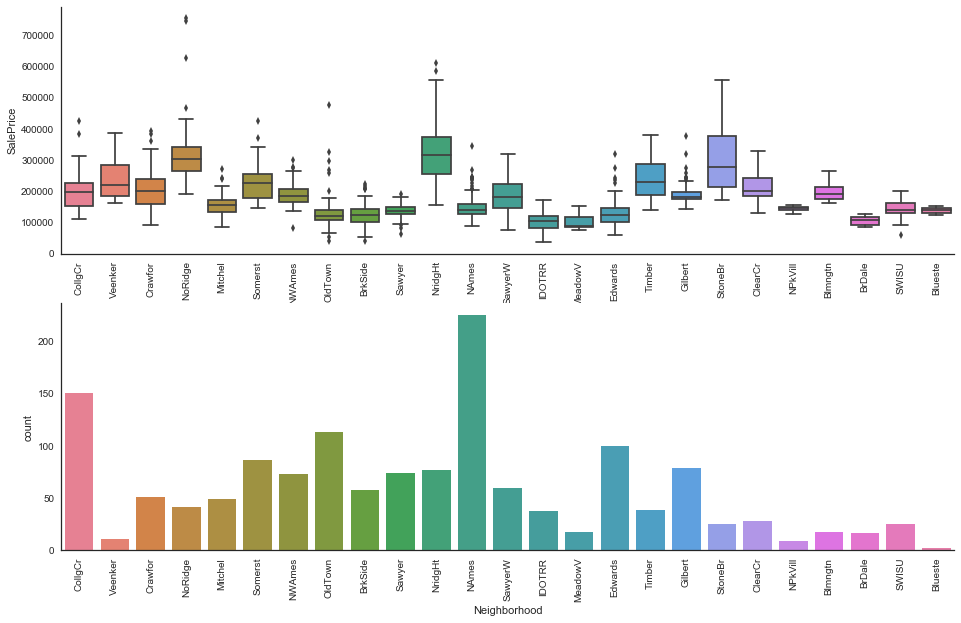

In [5]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(16,10))
sns.despine(left=False)

sns.boxplot("Neighborhood","SalePrice",data=homePricesTrain, palette="husl", ax=ax1)
sns.countplot(x="Neighborhood", data=homePricesTrain, palette="husl", ax=ax2)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.show()

#### Categorical variables

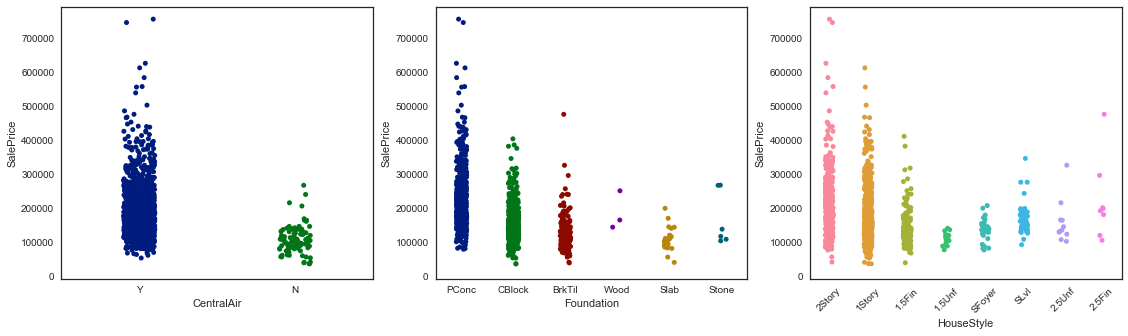

In [6]:
sns.set(style="white", palette="dark")
fig, axs = plt.subplots(ncols=3, figsize=(19,5))
plt.xticks(rotation=45)
sns.stripplot(x=homePricesTrain["CentralAir"], y=homePricesTrain["SalePrice"],jitter=True, ax=axs[0])
sns.stripplot(x=homePricesTrain["Foundation"], y=homePricesTrain["SalePrice"],jitter=True, ax=axs[1])
sns.stripplot(x=homePricesTrain["HouseStyle"], y=homePricesTrain["SalePrice"],jitter=True, ax=axs[2])
plt.show()

It looks like there is some correlation with higher sale price and central air. Additionally, we see correlations with the sale price and various foundation types, and various house Styles. 

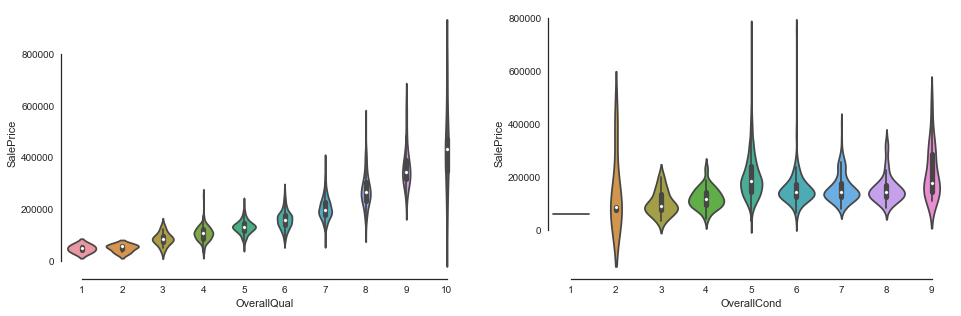

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
sns.violinplot("OverallQual","SalePrice",data=homePricesTrain, ax = axs[0])
sns.violinplot("OverallCond","SalePrice",data=homePricesTrain, ax = axs[1])

sns.despine(trim=True)

As the Overall Quality score increases, there is a positive correlation with the Sale Price. Interestingly, we do not see as strong of a correlation in the Overall Condition variable. 


# Modelling and Prediction

## Data Cleaning

The first step is to clean the data. The following variables have more than 15% of the values missing or NaN. 

In [8]:
del homePrices["SalePrice"]

nans=pd.isnull(homePrices).sum()
missing = nans[nans>(len(homePrices)*.15)]
missing = list(missing.index)
print(missing)

['Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'MiscFeature', 'PoolQC']


Remove the variables which are missing more than 15% of the values. Because there are so many values missing, it makes more sense to remove these fields from further analysis than to impute them with a median value.

In [9]:
homePrices.drop(homePrices[missing], axis = 1, inplace = True)

Next let's investigate which NaN values remain, and how many there are in each category: 

In [10]:
nans = pd.isnull(homePrices).sum()
nans[nans > 0] 

BsmtCond         82
BsmtExposure     82
BsmtFinSF1        1
BsmtFinSF2        1
BsmtFinType1     79
BsmtFinType2     80
BsmtFullBath      2
BsmtHalfBath      2
BsmtQual         81
BsmtUnfSF         1
Electrical        1
Exterior1st       1
Exterior2nd       1
Functional        2
GarageArea        1
GarageCars        1
GarageCond      159
GarageFinish    159
GarageQual      159
GarageType      157
GarageYrBlt     159
KitchenQual       1
MSZoning          4
MasVnrArea       23
MasVnrType       24
SaleType          1
TotalBsmtSF       1
Utilities         2
dtype: int64

**Missing Value Imputation:**

The Garage and Basement variables which are currently NaNs were also found to be the Garages and Basements with 0 square footage. The NaN's were replaced with the string "None" for further analysis. The GarageYearBlt is directly correlated with the Home year built, and there was no easy way to impute the NaN's, so this column was dropped. 

The remaining variables are replaced with mean values for the discrete variable, and mode values for the categorical variables.


In [11]:
homePrices.GarageCond.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageFinish.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageQual.fillna(value="None", axis = 'index', inplace=True)
homePrices.GarageType.fillna(value="None", axis = 'index', inplace=True)

homePrices['BsmtCond'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtExposure'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtFinType1'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtFinType2'].fillna(value="None", axis = 'index', inplace=True)
homePrices['BsmtQual'].fillna(value="None", axis = 'index', inplace=True)

homePrices = homePrices.drop("GarageYrBlt", 1)

nans = pd.isnull(homePrices).sum()
nans[nans>0]

BsmtFinSF1       1
BsmtFinSF2       1
BsmtFullBath     2
BsmtHalfBath     2
BsmtUnfSF        1
Electrical       1
Exterior1st      1
Exterior2nd      1
Functional       2
GarageArea       1
GarageCars       1
KitchenQual      1
MSZoning         4
MasVnrArea      23
MasVnrType      24
SaleType         1
TotalBsmtSF      1
Utilities        2
dtype: int64

In [12]:
# Replaces NAs in scalar fields with the mean value
homePrices = homePrices.fillna(homePrices.mean())

In [13]:
nans = pd.isnull(homePrices).sum()
stillmissing = nans[nans>0]
print(stillmissing)
stillmissing = stillmissing.index


Electrical      1
Exterior1st     1
Exterior2nd     1
Functional      2
KitchenQual     1
MSZoning        4
MasVnrType     24
SaleType        1
Utilities       2
dtype: int64


In [14]:
# Replaces NAs in categorical fields with the mode value
for feature in stillmissing:
    homePrices.loc[(homePrices[feature].isnull()), feature] = str(homePrices[feature].mode())

In [15]:
nans = pd.isnull(homePrices).sum()
stillmissing = nans[nans > 0]
stillmissing

Series([], dtype: int64)

** All missing values have been imputed. **



## Feature Engineering

### Feature Selection and Filtering

#### Logged Sale Price

As previously observed, the distribution of Sale Prices is right-skewed. One basic assumption of Linear Regression is that all variables are normally distributed. Introducing a variable, log of Sale Price is likely to yield a better model. 


In [16]:
logged_label = np.log(label)

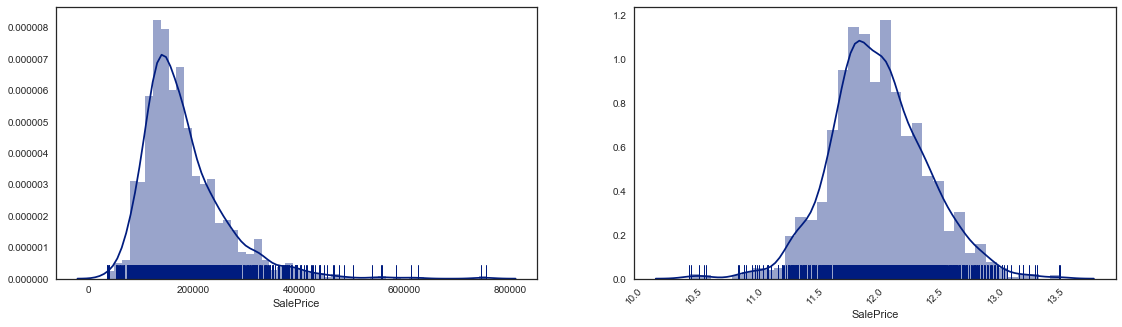

In [17]:
# Compare the distributiona of Sale Price versus logged Sale Price. The logged Sale Price is more normally distributed. 
sns.set(style="white", palette="dark")
fig, axs = plt.subplots(ncols=2, figsize=(19,5))
plt.xticks(rotation=45)
sns.distplot(label, kde=True, rug = True, ax = axs[0])
sns.distplot(logged_label, kde=True, rug = True,  ax = axs[1])
plt.show()

#### Other Engineered Variables: Total Square-Footage, Total Full Baths, Total Half Baths, and Deck Square-Footage


In [18]:
# Total square-footage of home, including basement sq-footage. 
homePrices["Total_sqft"] = homePrices["GrLivArea"] + homePrices["TotalBsmtSF"]

#Total Full and Half Baths
homePrices["totalFullBath"] = homePrices["BsmtFullBath"] + homePrices["FullBath"] 
homePrices["totalHalfBath"] = homePrices["BsmtHalfBath"] + homePrices["HalfBath"]

# Deck Square-Footage
homePrices["deck_porch_sqft"] = (homePrices["WoodDeckSF"] + homePrices["OpenPorchSF"] + 
                           homePrices["EnclosedPorch"] + homePrices["3SsnPorch"] + 
                           homePrices["ScreenPorch"])

homePricesCleaned = homePrices

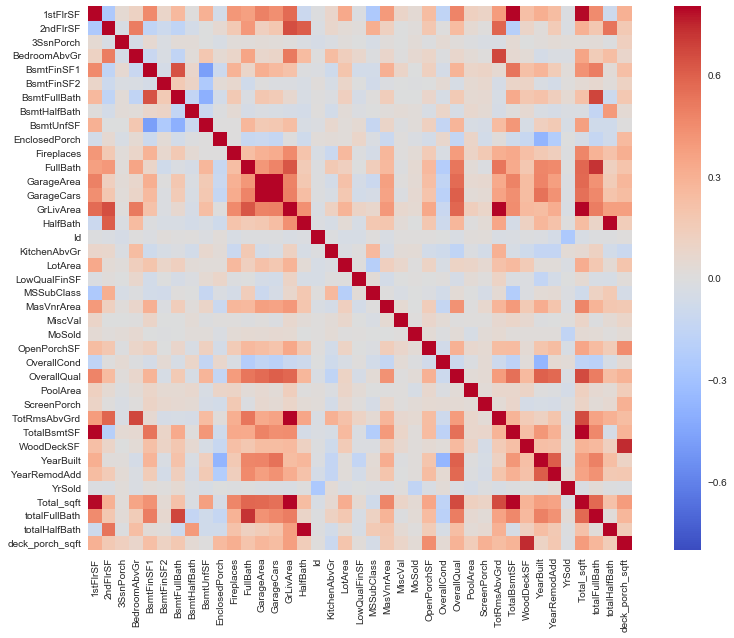

In [19]:
big_vars_of_interest = homePrices.columns

# Correlation matrix of numerical features
corrmat=homePrices[big_vars_of_interest].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True, cmap='coolwarm')
plt.show()

In [20]:
homePricesWithDummies = pd.get_dummies(data = homePrices)
# The MSSubClass variable has several numerical values, however each signify a different categorical class. We gather
# dummy variables for this class as well and append them to the existing data frame. 
homePricesMSDummies = pd.get_dummies(data=homePrices["MSSubClass"])
frames = [homePricesWithDummies, homePricesMSDummies]
homePricesWithDummies = pd.concat(frames, axis = 1)

homePricesWithDummies.columns.unique()

Index([     '1stFlrSF',      '2ndFlrSF',     '3SsnPorch',  'BedroomAbvGr',
          'BsmtFinSF1',    'BsmtFinSF2',  'BsmtFullBath',  'BsmtHalfBath',
           'BsmtUnfSF', 'EnclosedPorch',
       ...
                    70,              75,              80,              85,
                    90,             120,             150,             160,
                   180,             190],
      dtype='object', length=309)

### Filtering
We now filter based on how well the variable correlates with Sale Price. We split the training and test sets at this point, and reintroduce SalePrice to the training dataset. 

In [21]:
training_cleaned = homePricesWithDummies[homePricesWithDummies["Group_train"]==1]
training_cleaned.shape


(1460, 309)

In [22]:
test_cleaned = homePricesWithDummies[homePricesWithDummies["Group_test"]==1]
test_cleaned.shape

(1459, 309)

In [23]:
training_cleaned["loggedSalePrice"] = logged_label 

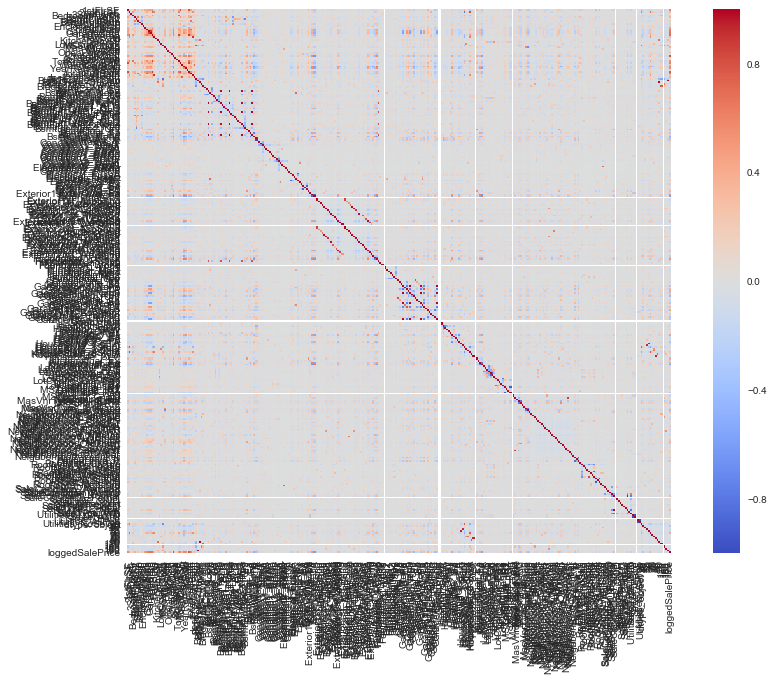

In [24]:
plt.figure(figsize = (15,5))
bigger_vars_of_interest = training_cleaned.columns

# Correlation matrix of numerical features
corrmat=training_cleaned[bigger_vars_of_interest].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True, cmap='coolwarm')
plt.show()

In [25]:
best_features = corrmat[corrmat["loggedSalePrice"] >= 0.20]
best_features = list(best_features.index)
best_features

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'HalfBath',
 'LotArea',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'Total_sqft',
 'totalFullBath',
 'totalHalfBath',
 'deck_porch_sqft',
 'BsmtExposure_Gd',
 'BsmtFinType1_GLQ',
 'BsmtQual_Ex',
 'BsmtQual_Gd',
 'CentralAir_Y',
 'Electrical_SBrkr',
 'ExterQual_Ex',
 'ExterQual_Gd',
 'Exterior1st_VinylSd',
 'Exterior2nd_VinylSd',
 'Foundation_PConc',
 'GarageCond_TA',
 'GarageFinish_Fin',
 'GarageFinish_RFn',
 'GarageQual_TA',
 'GarageType_Attchd',
 'GarageType_BuiltIn',
 'HeatingQC_Ex',
 'HouseStyle_2Story',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'LotShape_IR1',
 'MSZoning_RL',
 'MasVnrType_BrkFace',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'PavedDrive_Y',
 'SaleCondition_Partial',
 'SaleType_New',
 60,
 'loggedSal

In [26]:
best_neg_features = corrmat[corrmat["loggedSalePrice"] <= -0.20]
best_neg_features = list(best_neg_features.index)
best_neg_features

['BsmtExposure_No',
 'BsmtQual_TA',
 'CentralAir_N',
 'Electrical_FuseA',
 'ExterQual_TA',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'GarageCond_None',
 'GarageFinish_None',
 'GarageFinish_Unf',
 'GarageQual_None',
 'GarageType_Detchd',
 'GarageType_None',
 'HeatingQC_TA',
 'KitchenQual_Fa',
 'KitchenQual_TA',
 'LotShape_Reg',
 'MSZoning_RM',
 'MasVnrType_None',
 'Neighborhood_Edwards',
 'Neighborhood_IDOTRR',
 'Neighborhood_OldTown',
 'PavedDrive_N',
 'SaleType_WD',
 30]

In [27]:
all_best_features = best_features + best_neg_features

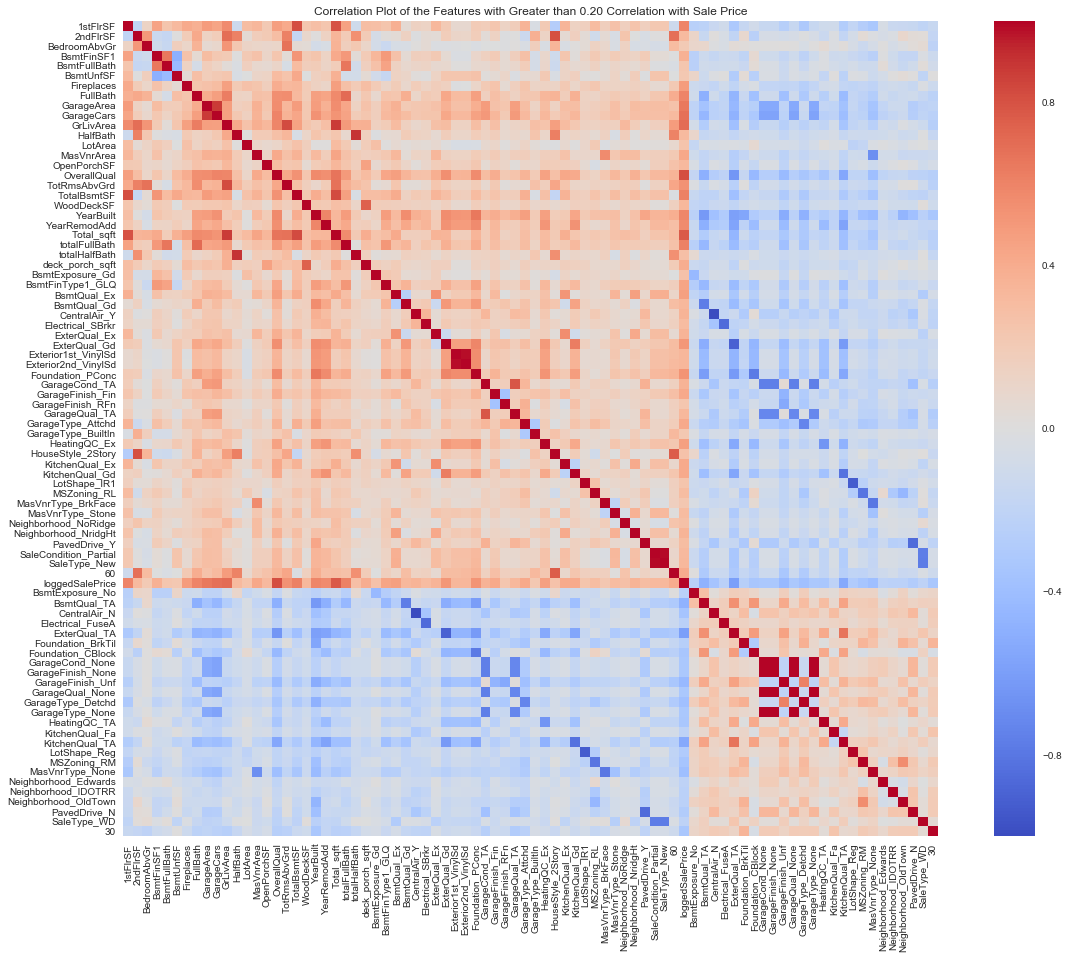

In [28]:
# Correlation matrix of numerical features
corrmat=training_cleaned[all_best_features].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True, annot=False, cmap='coolwarm')
plt.title("Correlation Plot of the Features with Greater than 0.20 Correlation with Sale Price")
plt.show()


Obviously, during the modelling phase, we can't include the "SalePrice" feature in our model except as the target variable. 

In [29]:
all_best_features.remove("loggedSalePrice")
del training_cleaned["loggedSalePrice"]

## Creating a Predictive Model

### Linear Regression

In [30]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score

regr = linear_model.LinearRegression()
Y = logged_label
X = training_cleaned[all_best_features]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [  1.77514342e-04   1.65940039e-04   1.14079378e-02  -4.09182208e-06
   1.21478614e-02  -2.77000180e-05   3.44973234e-02   1.32751308e-02
   3.25189717e-05   5.38054735e-02  -2.89692194e-05   2.07431235e-02
   1.71387987e-06   2.31136187e-05  -1.41803515e-04   7.18488243e-02
   1.17814985e-02   3.17689740e-05  -1.13612406e-04  -8.39331011e-04
   1.61278867e-03   2.79975459e-06   2.54229922e-02   1.07052859e-02
   2.14617341e-04   5.53361225e-02   1.73486757e-02   1.11151262e-01
   6.44935680e-02   5.04221303e-02  -5.13762567e-03   6.80125465e-02
   9.06693524e-02  -1.42673573e-02   1.96953856e-02   5.35184437e-02
   2.03380733e-02   6.82821233e-03   1.06766816e-03  -1.86471177e-02
   6.95250023e-02   4.68069506e-02   2.85958966e-02  -5.53477198e-02
   5.76644660e-02  -8.73539360e-03   8.36444918e-04   6.14494172e-03
   5.05841034e-02   5.36116645e-02   9.01324679e-02   6.86746144e-02
  -1.42054544e-02  -3.54926407e-02   9.75686436e-02   1.20234474e-02
  -1.16427577e-02

In [31]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regr, X, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross-Validated R-Squared of Linear Regression Model: 0.85 (+/- 0.17)


## K-Nearest Neighbors

### Find an optimal k-value by iterating over each value of k

In [32]:
Y = logged_label
X = stats.zscore(training_cleaned[all_best_features])

# search for an optimal unweighted value of K for KNN
k_range = range(1,20)
k_scores = []
for k in k_range: 
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(knn, X, Y, cv = 10)
    k_scores.append(scores.mean())

# search for an optimal weighted value of K for KNN
k_range = range(1,20)
k_scores_w = []
for k in k_range: 
    knn_w = neighbors.KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    scores_w = cross_val_score(knn_w, X, Y, cv = 10)
    k_scores_w.append(scores_w.mean())


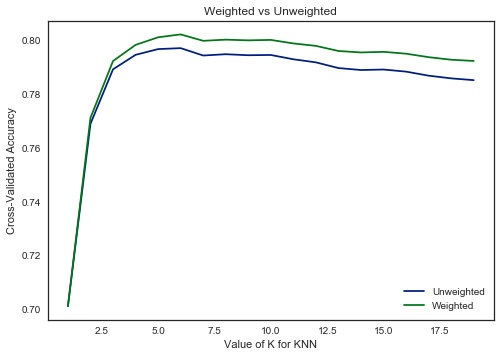

The optimal value for k (unweighted) is k=6
The optimal value for k (weighted by distance) is k=6


In [33]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores, label="Unweighted")
plt.plot(k_range, k_scores_w, label="Weighted")
plt.xlabel("Value of K for KNN")
plt.ylabel("Cross-Validated Accuracy")
plt.legend()
plt.title("Weighted vs Unweighted")
plt.show()

print("The optimal value for k (unweighted) is k={}".format(k_scores.index(max(k_scores))+1))
print("The optimal value for k (weighted by distance) is k={}".format(k_scores.index(max(k_scores))+1))

In [34]:
# Unweighted KNN (Cross-Validated)
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
score = cross_val_score(knn, X, Y, cv=10)
print("KNN Unweighted Mean Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Weighted KNN (Cross-Validated)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights = 'distance')
score_w = cross_val_score(knn_w, X, Y, cv=10)
print("KNN Weighted Mean Score: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

KNN Unweighted Mean Score: 0.80 (+/- 0.05)
KNN Weighted Mean Score: 0.80 (+/- 0.05)


## Random Forest Regression

In [35]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100)
X = pd.DataFrame(training_cleaned[all_best_features])
Y = logged_label

score = cross_val_score(rfr, X, Y, cv=10)
print("Random Forest: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Random Forest: 0.87 (+/- 0.05)


### What does this all mean???

Each strategy for modelling and predicting data has it's advantages and disadvantages. The goal is to find the method that can most accurately predict the outcome of interest, in this case the Sale Price of the home. This can be measured by finding the method with the $R^2$ closest to 1. 

The **Linear Regression** model scored well, however the variance is high. This is concerning. 

The **K-Nearest Neighbors Regression** model did not score as well, however the variance between cross-validated folds was smaller, so the prediction may be more dependable even if it does not perform as well. 

The **Random Forest Regression** model was the real winner here, with both high performance and low variance. Disadvantages to the random forest regression model is that it is harder to see which features are having the most impact on the model, especially compared to Linear Regression where one can pull coefficients to see the relative importances of the data.




# Methods for Further Optimization: 

## Dimensionality Reduction via PCA*

**\*aka Principle Components Analysis**

Principle Components Analysis utilizes linear combinations of the original variables such that the first principal component explains the largest variance between the variables, the second explains the next largest variance, etc. The principal components are uncorrelated to each other, and each successive component explains less and less variability. 

The first *eigenvalue* explains the largest amount of variance, the second explains the second largest, etc. 
As we reduce the dimensionality of the data, the goal is to capture the most variance in the fewest number of *eigenvalues*. This can be intuitively viewed in a scree plot. 


In [36]:
# Turn variable string values into integer values
homePrices_with_dummies = pd.get_dummies(data = homePricesCleaned)

# Log transform
logged_homePrices_with_dummies = np.log(homePrices_with_dummies)

# Remove -infs in the dataset
logged_homePrices_with_dummies[logged_homePrices_with_dummies==-np.inf] = 0

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)



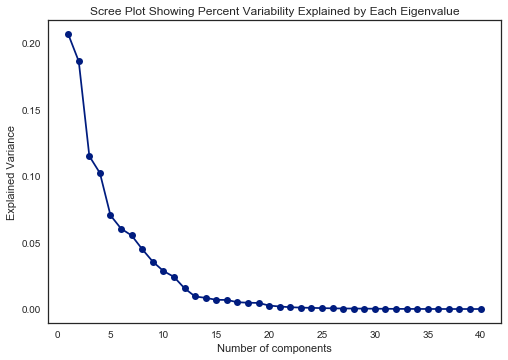

The first 7 components can explain 79.0% of the variance in the data.
Just eleven principal components can explain 95.0% of the variance in the data.


In [38]:
plt.figure(1, figsize=(9, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])

dat = range(1, 41)
plt.plot(dat, variance, marker='o')

plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.title("Scree Plot Showing Percent Variability Explained by Each Eigenvalue")

plt.show()

n_var = float(list(variance[:7].sum())[0])
print("The first 7 components can explain {}% of the variance in the data.".format(n_var *100//1))

n_var = float(list(variance[:13].sum())[0])
print("Just eleven principal components can explain {}% of the variance in the data.".format(n_var *100//1))

We see that we can reduce the dimensionality of our dataset using Principal Component Analysis. The 82 variables included in the original dataset can be reduced to 11 components to explain 95.0% of the variances in the Sales Price. 

### PCA Plot and Label Creation: 

Let's visualize the stratification in the data separating upper half and lower half of homes using a PCA plot. 


In [39]:
label.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Let's explore what makes a home sell in the top half versus the bottom half. Class1 includes homes which sold for more than \$163k, and Class2 sold for \$163k or less. 



In [40]:
class1 = label[label > 163000]
class2 = label[label <= 163000]


print(len(class1))
print(len(class2))

728
732


In [41]:
# Transpose the class labels
class1T = class1.T
class2T = class2.T

pca = PCA(n_components=2, whiten=True)
transf = pca.fit_transform(logged_homePrices_with_dummies)
transf_label = label.T


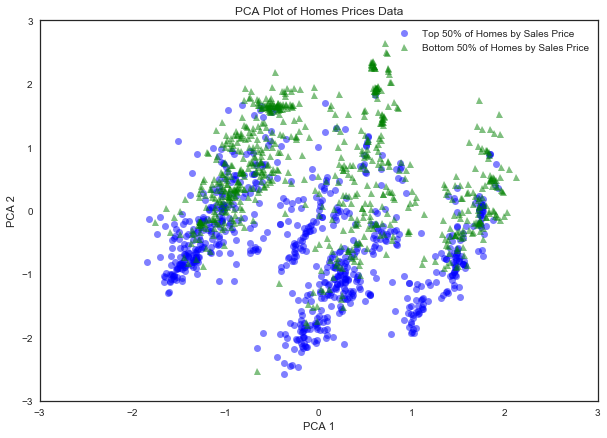

In [42]:
plt.figure(figsize=(10, 7))
plt.plot(transf[class1T.index,0],transf[class1T.index,1], 'o', 
         markersize=7, color='blue', alpha=0.5, 
         label='Top 50% of Homes by Sales Price')
plt.plot(transf[class2T.index,0],transf[class2T.index,1], '^', 
         markersize=7, color='green', alpha=0.5, 
         label='Bottom 50% of Homes by Sales Price')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend()
plt.title("PCA Plot of Homes Prices Data")
plt.show()

PCA is useful for reducing the dimensionality of the data. Above, the first two PCA components (aka *eigenvectors*) show differences in the two groupings of homes. Each PCA component is by definition uncorrelated to other PCA components, which makes this analysis well-suited to use with Linear Regression. One basic assumption of Linear Regression is that all variables are uncorrelated to each other. Let's see if we can improve on our existing Linear Regression Model using PCA. 

In [43]:
pca = PCA(n_components=50, whiten=True)
a = pca.fit(logged_homePrices_with_dummies)
variance = pd.DataFrame(pca.explained_variance_ratio_)

X_pca = pca.fit_transform(X)


In [44]:
regr.fit(X_pca, Y)
score = cross_val_score(regr, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross-Validated R-Squared of Linear Regression Model: 0.85 (+/- 0.17)


In [49]:
rfr.fit(X_pca, Y)
score = cross_val_score(rfr, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of Random Forest Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross-Validated R-Squared of Random Forest Model: 0.80 (+/- 0.06)


In [50]:
knn_w.fit(stats.zscore(X_pca), Y)
score = cross_val_score(knn_w, X_pca, Y, cv=10)
print("Cross-Validated R-Squared of KNN Model: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Cross-Validated R-Squared of KNN Model: 0.72 (+/- 0.10)


## Results

PCA Analysis allowed us to lessen our computational requirements by reducing the number of variables in the dataset to only 40 variables, without any drop in performance in the Linear Regression Model. However, the Random Forest and KNN models did undergo a weakening of their predictive power. 

I conclude that the best model to suit our current needs is the Random Forest Regression without PCA components. This takes into account the size of the dataset, our current computational power, and our prioritization of accurate and dependable predictions. 

# Test the Predictive Model on the Test Set

In [47]:
# Models
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
regr = linear_model.LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)

# Use the best model for testing
best_model = rfr
best_model.fit(X,Y)
best_model.predict(X=test_cleaned[all_best_features])
logged_prediction = best_model.predict(X=test_cleaned[all_best_features])

# The Sales Price predictions are still in logarithmic form. The exponential 
# of the prediction array is taken to return actual dollar amounts. 
prediction = np.exp(logged_prediction)
prediction = pd.DataFrame(prediction)

# Formatting the data for submission
frames = [test_cleaned["Id"], prediction]
predictions = pd.concat(frames, axis = 1)

predictions.columns = ["Id", "SalePrice"]
predictions.set_index("Id", inplace = True)

# Name output file
predictions.to_csv('/Users/jacquelynzuker/Desktop/predictions.csv')